## 加载依赖库

In [35]:
import math #rmse

from IPython import display #在notebook中展示图形
from matplotlib import cm,gridspec #未知作用
import matplotlib.pyplot as plt #绘图，可视化
import numpy as np #array对象
import pandas as pd #数据处理
from sklearn import metrics #模型评估
import tensorflow as tf #主角，算法框架
from tensorflow.python.data import Dataset #构建可用于训练的数据格式

tf.logging.set_verbosity(tf.logging.ERROR) #加载错误设置？
pd.options.display.max_rows = 10 #展示行限制
pd.options.display.float_format = '{:.1f}'.format #展示数值类型

### 数据集

In [36]:
california_housing_dataframe = pd.read_csv('/Users/meininghang/Downloads/california_housing_test.csv')

### 随机化处理

In [37]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index)) #指定随机行名称索引

### 对过大的列进行数值调整

In [38]:
california_housing_dataframe['median_house_value'] /= 1000.0 #注意使用浮点数

## 查看统计信息

In [39]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,-119.6,35.6,28.8,2599.6,530.0,1402.8,489.9,3.8,205.8
std,2.0,2.1,12.6,2155.6,415.7,1030.5,365.4,1.9,113.1
min,-124.2,32.6,1.0,6.0,2.0,5.0,2.0,0.5,22.5
25%,-121.8,33.9,18.0,1401.0,291.0,780.0,273.0,2.5,121.2
50%,-118.5,34.3,29.0,2106.0,437.0,1155.0,409.5,3.5,177.6
75%,-118.0,37.7,37.0,3129.0,636.0,1742.8,597.2,4.7,264.0
max,-114.5,41.9,52.0,30450.0,5419.0,11935.0,4930.0,15.0,500.0


## 建模

- 标签（y'）: median_house_value
- 特征（x）: total_rooms
- API : tf.estimator 提供的LinearRegressor，训练，评估和预测的。

###  step 1： 特征与特征列

#### 输入想要变换为特征列的列

In [40]:
my_feature = california_housing_dataframe[['total_rooms']]
feature_columns = [tf.feature_column.numeric_column('total_rooms')] #转变成功

#### 变为特征列

### step 2 : 定义目标，即预测值y'

In [41]:
targets = california_housing_dataframe['median_house_value']

### step 3: 配置LinearRegressor

- 模型： LinearRegressor
- 训练：小批量SGD下降法（GradientDescentOptimizer）
- 步长：learning_rate(学习速率）
- 梯度裁剪: clip_gradients_by_norm

#### 梯度下降法

In [42]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0) #裁剪
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

#### 模型+特征列+学习速率

### step 4 : 定义输入函数

> 基本步骤
1. 提取的数据为pandas对象,需要转换为numpy数组字典格式;
2. 构建dataset对象后,使用batch_size拆分为多批数据,num_epochs为重复周期数;
3. shuffle为随机化提取数据,即置乱, buffer_size控制抽取数据集大小;
4. 迭代

In [49]:
#global features
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
    #转换数据类型

   # features = {key:np.array(value) for key,value in dict(features).items()}
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    #global features
    #构建数据集,,指定批次和重复周期
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs) #一直重复
    
    #随机化,置乱
    if shuffle:
        ds = ds.shuffle(buffer_size=10000) #控制数据集大小
    
    #迭代
    features,labels = ds.make_one_shot_iterator().get_next() #构建迭代器,向模型传递下一批数据
    return features,labels

###  step 5 :run

In [50]:
_ = linear_regressor.train(
    input_fn = lambda : my_input_fn(my_feature, targets),
    steps = 100
) #


###  step 6 : 评估

#### 预测函数

In [51]:
prediction_input_fn = lambda : my_input_fn(my_feature,targets,num_epochs=1,shuffle=False) #作为示例,因此不置乱数据和重复运行

#### 模型

In [52]:
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

#### 格式变为array,便于衡量

In [53]:
predictions = np.array([item['predictions'][0] for item in predictions])

#### 输出具体信息

In [64]:
m_s_e = metrics.mean_squared_error(predictions,targets) #均方误差
r_m_s_e = math.sqrt(m_s_e) #均方根误差
print('MSE(on training data):%0.3f' % m_s_e) #小数点
print('MSE(on training data):%0.4f' % m_s_e)
print('RMSE(on training data):%0.3f' % r_m_s_e)

MSE(on training data):55107.094
MSE(on training data):55107.0941
RMSE(on training data):234.749


- 解读RMSE,MSE的作用是得到RMSE
- 比较得到的RMSE与预测值min和max的差值

In [66]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % r_m_s_e)

Min. Median House Value: 22.500
Max. Median House Value: 500.001
Difference between Min. and Max.: 477.501
Root Mean Squared Error: 234.749


###  缩小误差

#### 根据原始数据观察模型预测和既有目标情况

In [69]:
calibration_data = pd.DataFrame()  #将其构造为dataframe对象
calibration_data['predictions'] = pd.Series(predictions) #预测值列
calibration_data['targets'] = pd.Series(targets) #目标值列
calibration_data.describe()

,predictions,targets
count,3000.0,3000.0
mean,0.1,205.8
std,0.1,113.1
min,0.0,22.5
25%,0.1,121.2
50%,0.1,177.6
75%,0.2,264.0
max,1.5,500.0


### 可视化

#### 获得sample

In [70]:
sample = california_housing_dataframe.sample(n=300) #n控制大小

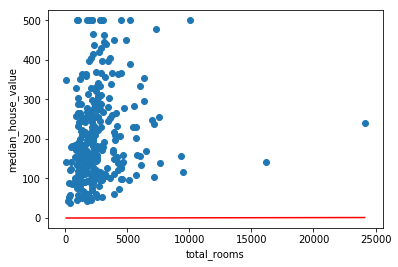

In [78]:
#特征列最值
x_0 = sample.total_rooms.min()
x_1 = sample.total_rooms.max()

#训练得到的权重和偏差,即w和b
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

#预测目标最值
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

#线
plt.plot([x_0,x_1],[y_0,y_1],c='r') #颜色为红色

#轴标签
plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

#散点图
plt.scatter(sample['total_rooms'],sample['median_house_value'])

#notebook中展示
plt.show()

##  调参

In [93]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
      
        
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

### 控制RMSE


Training model...
RMSE (on training data):
  period 00 : 222.95
  period 01 : 211.71
  period 02 : 201.26
  period 03 : 191.72
  period 04 : 183.25
  period 05 : 177.34
  period 06 : 172.29
  period 07 : 168.18
  period 08 : 168.18
  period 09 : 164.45
Model training finished.


,predictions,targets
count,3000.0,3000.0
mean,109.2,205.8
std,90.5,113.1
min,0.3,22.5
25%,58.8,121.2
50%,88.5,177.6
75%,131.4,264.0
max,1278.9,500.0


Final RMSE (on training data): 164.45


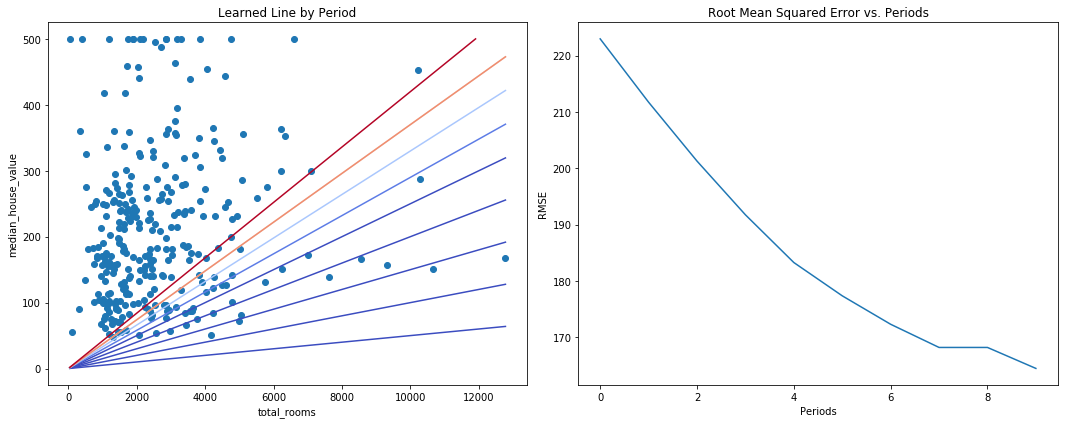

In [94]:
train_model(
    learning_rate = 0.0001,
    steps = 100,
    batch_size = 1
)

### 尝试其他特征和不同的参数

Training model...
RMSE (on training data):
  period 00 : 228.81
  period 01 : 222.92
  period 02 : 217.23
  period 03 : 211.73
  period 04 : 206.46
  period 05 : 201.43
  period 06 : 196.65
  period 07 : 192.33
  period 08 : 188.76
  period 09 : 185.11
Model training finished.


,predictions,targets
count,3000.0,3000.0
mean,68.2,205.8
std,50.1,113.1
min,0.2,22.5
25%,37.9,121.2
50%,56.1,177.6
75%,84.7,264.0
max,580.0,500.0


Final RMSE (on training data): 185.11


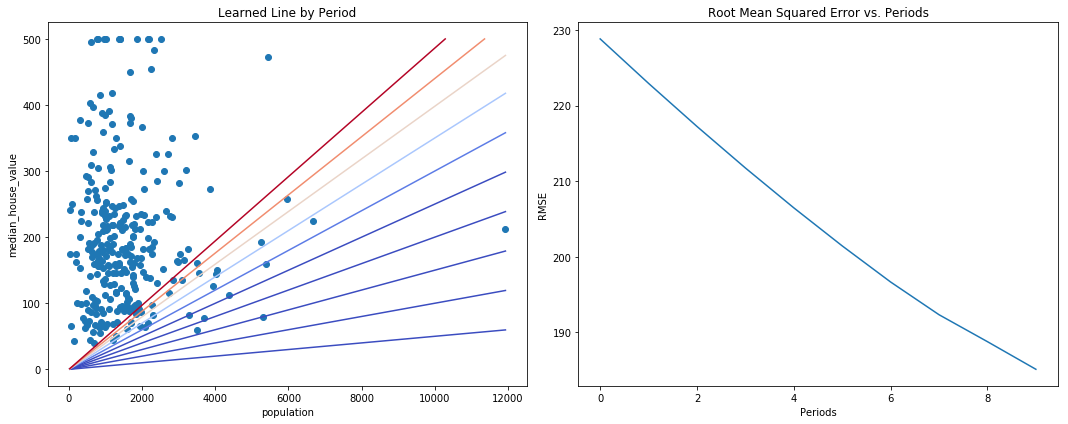

In [95]:

train_model(
    learning_rate = 0.00002,
    steps = 500,
    batch_size =5,
    input_feature = 'population'
)